# Papers:
- [Deep Fake Detector](http://cs230.stanford.edu/projects_winter_2019/reports/15812450.pdf)

In [1]:
import os
import cv2
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

In [2]:
CLASSES_IDS = {
    'REAL': 0,
    'FAKE': 1
}

CLASSES_NAMES = {
    0: 'real',
    1: 'fake'
}

class DeepFakeDataset(Dataset):
    """Fake vs Real."""

    def __init__(self, root_dir, split='train', transform=None):
        assert split in ['train', 'test']
        
        self.__root_dir = root_dir
        self.__split = split
        self.__transform = transform

        self.__split_dir = os.path.join(root_dir, split)
        self.__classes = os.listdir(self.__split_dir)

        self.__image_labels = []
        self.__images = []

        for cls in self.__classes:
            for image in os.listdir(os.path.join(self.__split_dir, cls)):
                self.__image_labels.append(cls)
                self.__images.append(image)

        assert len(self.__images) == len(self.__image_labels)

    @property
    def split(self):
        return self.__split

    @property
    def num_classes(self):
        return len(self.__classes)

    def __len__(self):
        return len(self.__images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_label = self.__image_labels[idx]
        image_name = os.path.join(self.__root_dir,
                                  self.__split,
                                  image_label,
                                  self.__images[idx])
        
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.__transform:
            image = self.__transform(image)

        probs = np.zeros((self.num_classes, ))
        probs[CLASSES_IDS[image_label]] = 1

        return image, probs

In [3]:
def plt_dataset(dataset, indices, row_size=8, title=None):
    fig, ax = plt.subplots(nrows=math.ceil(len(indices) / row_size), ncols=row_size, figsize=(12, 8))

    if title:
        fig.suptitle(f'Fake vs. Real Dataset: {title}', fontsize=28)
    else:
        fig.suptitle('Fake vs. Real Dataset', fontsize=28)
    
    for i, index in enumerate(indices):
        image, probs = dataset[index]
        label_id = np.argmax(probs)

        if type(image) is torch.tensor:
            image = image.detach().cpu().numpy()
            image = image.transpose((1, 2, 0))

        grid_i = i // row_size
        grid_j = i % row_size

        ax[grid_i, grid_j].axis("off")
        ax[grid_i, grid_j].set_title(f"{CLASSES_NAMES[label_id]} ({label_id})")
        ax[grid_i, grid_j].imshow(image)

Split train
It contains 18618 images


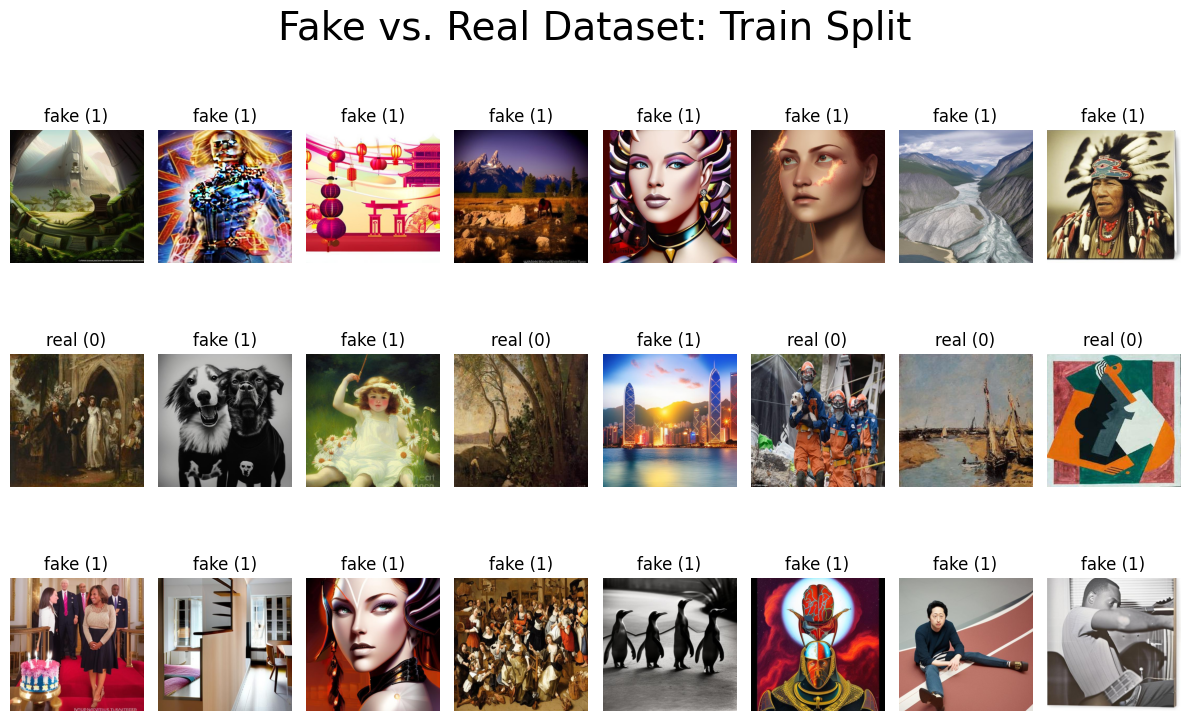

In [4]:
dataset = DeepFakeDataset('./temp/dataset')
indices = np.random.randint(0, len(dataset), 24)

print(f'Split {dataset.split}')
print(f'It contains {len(dataset)} images')

plt_dataset(dataset, indices, title='Train Split')
plt.tight_layout()
plt.show()

Split test
It contains 2181 images


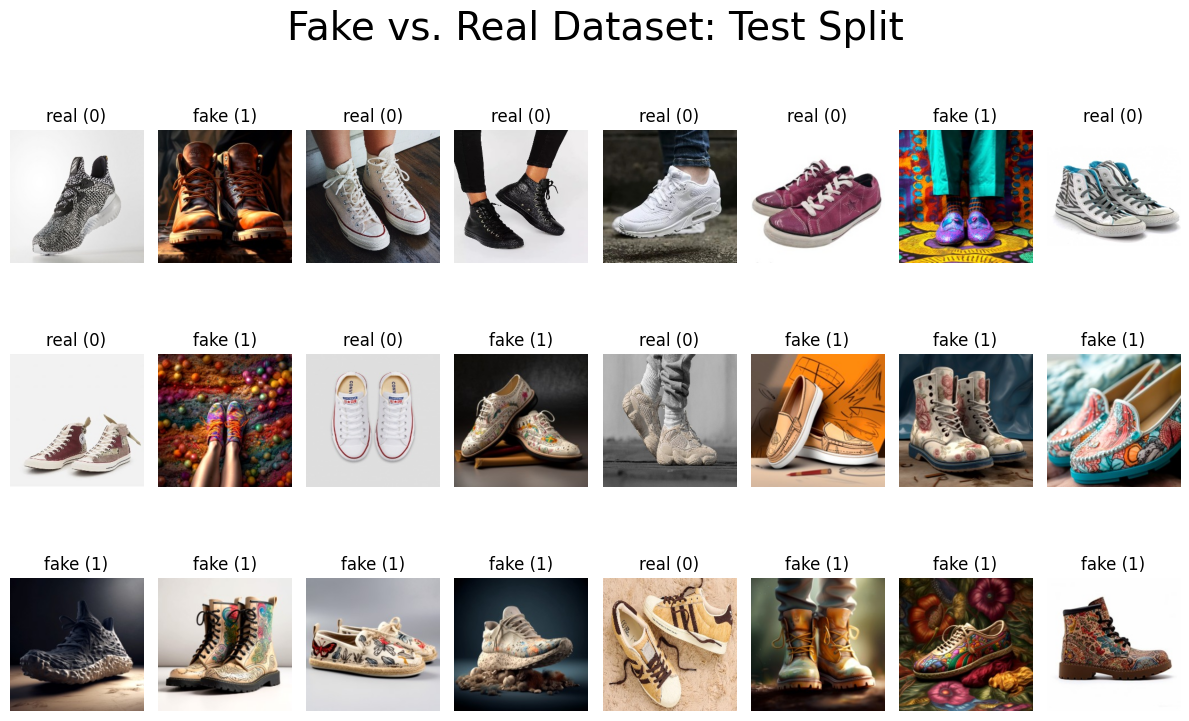

In [5]:
dataset = DeepFakeDataset('./temp/dataset', split='test')
indices = np.random.randint(0, len(dataset), 24)

print(f'Split {dataset.split}')
print(f'It contains {len(dataset)} images')

plt_dataset(dataset, indices, title='Test Split')
plt.tight_layout()
plt.show()

# Training+Validation utils

In [6]:
def get_accuracy(trues, 
                 predictions):
    trues, predictions = trues.detach().cpu(), predictions.detach().cpu()
    return (np.argmax(trues, axis=1) == np.argmax(predictions, axis=1)).mean(dtype=torch.float32)

def train(model, 
          train_dataloader, 
          criterion, 
          optimizer, 
          scheduler, 
          grad_clip, 
          device='cpu'):
    model.to(device)
    model.train()

    losses = []
    accuracies = []
    
    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs.float(), labels.float()

        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()

        if grad_clip: 
            torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        losses.append(loss.item())
        accuracies.append(get_accuracy(labels, predictions))

    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    return model, mean_accuracy, mean_loss

def validation(model,
               val_dataloader,
               criterion,
               device='cpu'):    
    model.to(device)
    model.eval()
    
    losses = []
    accuracies = []

    for inputs, labels in tqdm(val_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs, labels = inputs.float(), labels.float()
        
        with torch.no_grad():   
            predictions = model(inputs)

            loss = criterion(predictions, labels)

            losses.append(loss.item())
            accuracies.append(get_accuracy(labels, predictions))

    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    return mean_accuracy, mean_loss

In [7]:
def create_net(num_classes,
               model_type,
               pretrained):
    if pretrained and model_type == 'resnet18':
        weights = 'ResNet18_Weights.IMAGENET1K_V1'
    elif pretrained and model_type == 'resnet34':
        weights = 'ResNet34_Weights.IMAGENET1K_V1'
    elif pretrained and model_type == 'resnet50':
        weights = 'ResNet50_Weights.IMAGENET1K_V2'
    else:
        weights = None
    
    if model_type == 'resnet18':
        model = torchvision.models.resnet18(weights=weights)
    elif model_type == 'resnet34':
        model = torchvision.models.resnet34(weights=weights)
    elif model_type == 'resnet50':
        model = torchvision.models.resnet50(weights=weights)
    else:
        raise Exception(f'Unknown model type: {model_type}')

    num_inputs = model.fc.in_features
    model.fc = torch.nn.Linear(num_inputs, num_classes)
    return model

In [8]:
train_dataset = DeepFakeDataset('./temp/dataset', split='train', transform=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((240, 240)),
]))
test_dataset = DeepFakeDataset('./temp/dataset', split='test', transform=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
]))

In [9]:
def save_state(epoch,
               config,
               model,
               optimizer,
               file_path="./best_state.pth"):
    state = {
    'epoch': epoch,
    'config': config,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    }
    
    torch.save(state, file_path)

In [10]:
def run_experiment(config):
    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS']) 
    test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])
    
    model = create_net(num_classes=config['NUM_CLASSES'], model_type=config['MODEL'], pretrained=config['MODEL_PRETRAINED'])
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['LR'], weight_decay=config['WEIGHT_DECAY'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                    config['LR'], 
                                                    epochs=config['NUM_EPOCHS'], 
                                                    steps_per_epoch=len(train_loader))
    
    train_accuracy = []
    train_loss = []
    
    val_accuracy = []
    val_loss = []
    
    best_accuracy = 0 
    
    for epoch in range(config['NUM_EPOCHS']):
        print(f"Epoch #{epoch} started.")
        
        model, t_acc, t_loss = train(model, train_loader, criterion, optimizer, scheduler, grad_clip=config['GRAD_CLIP'], device=config['DEVICE'])
        train_accuracy.append(t_acc)
        train_loss.append(t_loss)
    
        print(f"Train loss: {t_loss}, accuracy: {t_acc}")
    
        v_acc, v_loss = validation(model, test_loader, criterion, device=config['DEVICE'])
        val_accuracy.append(v_acc) 
        val_loss.append(v_loss)
    
        print(f"Validation loss: {v_loss}, accuracy: {v_acc}")
    
        if v_acc > best_accuracy:
            print(f"Saving best accuracy so far, {v_acc}")
            best_accuracy = v_acc
            save_state(epoch, config, model, optimizer, file_path=f"./temp/best_state_{v_acc:.2f}.pth")

    return train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy

In [11]:
def plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    ax[0, 0].set_title("Train loss")
    ax[0, 0].plot(train_loss)
    
    ax[0, 1].set_title("Train accuracy")
    ax[0, 1].plot(train_accuracy)
    
    ax[1, 0].set_title("Validation loss")
    ax[1, 0].plot(val_loss)
    
    ax[1, 1].set_title("Validation accuracy")
    ax[1, 1].plot(val_accuracy)
    
    plt.tight_layout()
    plt.show()

# ResNet18

- No Weights
- Batch size: **32**
- Gradient clip: **0.1**
- Weight Decay: **0.0003**
- **25** epochs

In [12]:
config = dict()
config['MODEL'] = 'resnet18'
config['MODEL_PRETRAINED'] = False
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 32
# x.com/karpathy/status/801621764144971776
config['LR'] = 3e-4
config['GRAD_CLIP'] = 0.1
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 1e-4
config['NUM_EPOCHS'] = 25

In [13]:
train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy = run_experiment(config)

Epoch #0 started.


100%|█████████████████████████████████████████████████████████████████████████████████| 582/582 [53:44<00:00,  5.54s/it]


Train loss: 0.37658902774868963, accuracy: 0.8283976316452026


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [01:08<00:00,  1.01it/s]


Validation loss: 1.306021852661734, accuracy: 0.6566123366355896
Saving best accuracy so far, 0.6566123366355896
Epoch #1 started.


100%|█████████████████████████████████████████████████████████████████████████████████| 582/582 [37:13<00:00,  3.84s/it]


Train loss: 0.2643596730050967, accuracy: 0.8881467580795288


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [01:03<00:00,  1.09it/s]


Validation loss: 0.9540222995523093, accuracy: 0.5730072259902954
Epoch #2 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:23<00:00,  3.65s/it]


Train loss: 0.23633780586453237, accuracy: 0.8984643220901489


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:43<00:00,  1.60it/s]


Validation loss: 1.9923958583478478, accuracy: 0.6707427501678467
Saving best accuracy so far, 0.6707427501678467
Epoch #3 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:35<00:00,  3.67s/it]


Train loss: 0.20741046859508322, accuracy: 0.9114583134651184


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.64it/s]


Validation loss: 1.024712181177692, accuracy: 0.5449275374412537
Epoch #4 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:51<00:00,  3.59s/it]


Train loss: 0.18770491904051034, accuracy: 0.9212636947631836


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.66it/s]


Validation loss: 1.3027458352887111, accuracy: 0.5907608866691589
Epoch #5 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:37<00:00,  3.57s/it]


Train loss: 0.1752063197266195, accuracy: 0.9219741225242615


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.63it/s]


Validation loss: 1.3098492015531098, accuracy: 0.4913043677806854
Epoch #6 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:52<00:00,  3.60s/it]


Train loss: 0.1550237248368446, accuracy: 0.9327501654624939


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [01:03<00:00,  1.09it/s]


Validation loss: 1.4402268528938293, accuracy: 0.5339673757553101
Epoch #7 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:03<00:00,  3.61s/it]


Train loss: 0.14723651158812223, accuracy: 0.9360916018486023


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.60it/s]


Validation loss: 1.4854269140008567, accuracy: 0.4591485559940338
Epoch #8 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:46<00:00,  3.59s/it]


Train loss: 0.13463112555245815, accuracy: 0.9441993832588196


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.63it/s]


Validation loss: 1.633597681487816, accuracy: 0.6086956262588501
Epoch #9 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:50<00:00,  3.59s/it]


Train loss: 0.12205943194317193, accuracy: 0.9497299194335938


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.67it/s]


Validation loss: 1.5513990400494009, accuracy: 0.5964673757553101
Epoch #10 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:24<00:00,  3.55s/it]


Train loss: 0.10738336874485732, accuracy: 0.9567267298698425


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.66it/s]


Validation loss: 1.6581554037073385, accuracy: 0.44465580582618713
Epoch #11 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:29<00:00,  3.56s/it]


Train loss: 0.09501867133106306, accuracy: 0.9603613615036011


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.62it/s]


Validation loss: 1.3640992028125818, accuracy: 0.6204710006713867
Epoch #12 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:37<00:00,  3.57s/it]


Train loss: 0.07846498835385422, accuracy: 0.9692745804786682


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.61it/s]


Validation loss: 2.205283288506494, accuracy: 0.446739137172699
Epoch #13 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [34:59<00:00,  3.61s/it]


Train loss: 0.06014999329161277, accuracy: 0.9769651889801025


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [01:00<00:00,  1.15it/s]


Validation loss: 2.058978370998217, accuracy: 0.5295289754867554
Epoch #14 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [36:05<00:00,  3.72s/it]


Train loss: 0.0459588908724794, accuracy: 0.9824833273887634


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.66it/s]


Validation loss: 2.6380705306495447, accuracy: 0.5249094367027283
Epoch #15 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [44:45<00:00,  4.61s/it]


Train loss: 0.029965299780031405, accuracy: 0.98931485414505


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Validation loss: 2.467954605385877, accuracy: 0.6034420132637024
Epoch #16 started.


100%|█████████████████████████████████████████████████████████████████████████████████| 582/582 [50:55<00:00,  5.25s/it]


Train loss: 0.0218198732395696, accuracy: 0.9920532703399658


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [00:53<00:00,  1.30it/s]


Validation loss: 2.9555594908154528, accuracy: 0.573369562625885
Epoch #17 started.


100%|███████████████████████████████████████████████████████████████████████████████| 582/582 [1:28:41<00:00,  9.14s/it]


Train loss: 0.016723946350865878, accuracy: 0.994093656539917


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.60it/s]


Validation loss: 2.602476554504339, accuracy: 0.5570651888847351
Epoch #18 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:20<00:00,  3.64s/it]


Train loss: 0.008199099927963091, accuracy: 0.9976374506950378


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:42<00:00,  1.62it/s]


Validation loss: 2.8655546635821247, accuracy: 0.5925724506378174
Epoch #19 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:42<00:00,  3.68s/it]


Train loss: 0.004498615136437421, accuracy: 0.9988723993301392


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:54<00:00,  1.27it/s]


Validation loss: 3.186191341151362, accuracy: 0.573097825050354
Epoch #20 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [35:00<00:00,  3.61s/it]


Train loss: 0.0020020066783977245, accuracy: 0.9997852444648743


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:41<00:00,  1.65it/s]


Validation loss: 3.17807792580646, accuracy: 0.5866848230361938
Epoch #21 started.


100%|███████████████████████████████████████████████████████████████████████| 582/582 [46:40<00:00,  4.81s/it]


Train loss: 0.001739340928717953, accuracy: 0.9997315406799316


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [01:01<00:00,  1.12it/s]


Validation loss: 3.159367749656456, accuracy: 0.5776268243789673
Epoch #22 started.


100%|███████████████████████████████████████████████████████████████████████████████| 582/582 [1:53:44<00:00, 11.73s/it]


Train loss: 0.0015505241598783403, accuracy: 0.9997315406799316


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:59<00:00,  1.16it/s]


Validation loss: 3.0937201942222705, accuracy: 0.5875905752182007
Epoch #23 started.


100%|█████████████████████████████████████████████████████████████████████| 582/582 [1:02:48<00:00,  6.47s/it]


Train loss: 0.0005911066836674342, accuracy: 1.0


100%|█████████████████████████████████████████████████████████████████████████| 69/69 [00:59<00:00,  1.15it/s]


Validation loss: 3.2162052272022637, accuracy: 0.5726449489593506
Epoch #24 started.


100%|█████████████████████████████████████████████████████████████████████| 582/582 [1:15:30<00:00,  7.79s/it]


Train loss: 0.0006882102570764884, accuracy: 0.9998925924301147


100%|███████████████████████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Validation loss: 3.206580614698106, accuracy: 0.5726449489593506


In [14]:
print(f"ResNet18+'No Wieghts' best accuracy is {best_accuracy}")

ResNet18+'No Wieghts' best accuracy is 0.6707427501678467


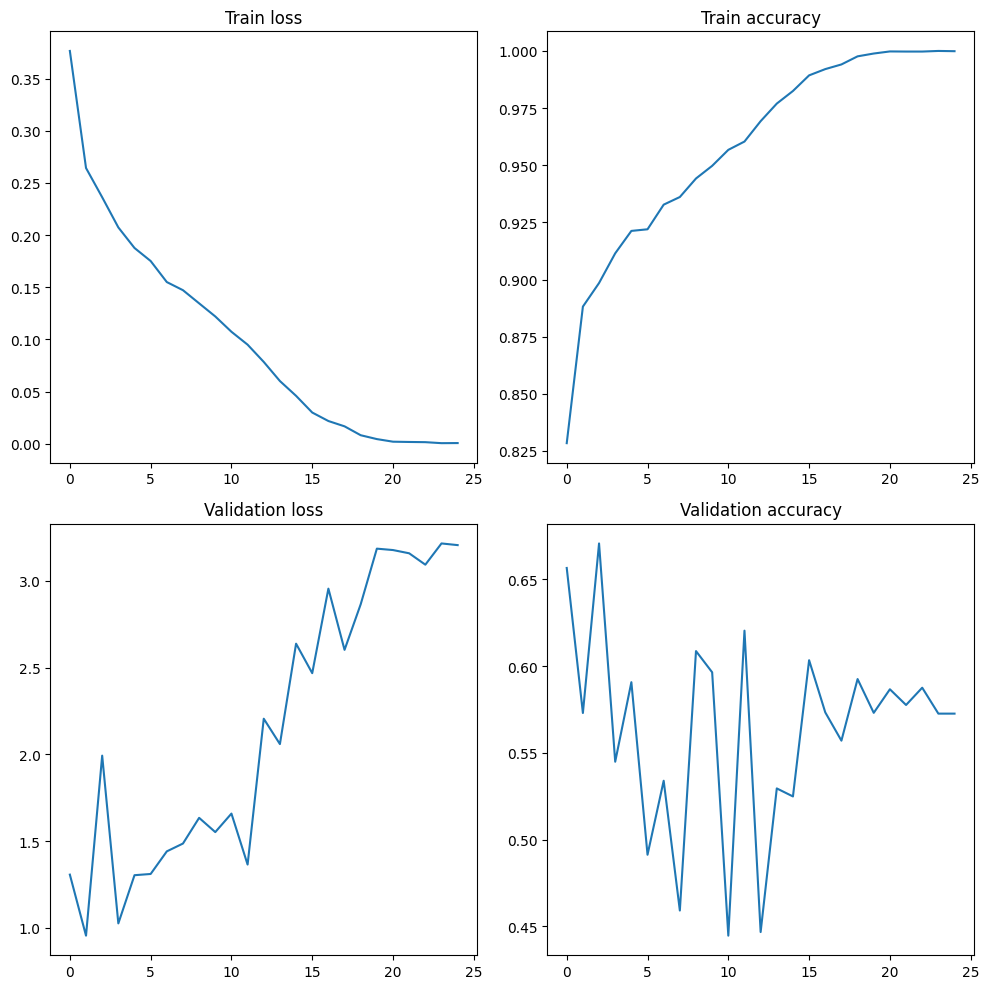

In [15]:
plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy)

# ResNet 18

- No Weights
- Batch size: **8**
- Gradient clip: **disabled**
- Weight Decay: **disabled**
- **20** epochs

In [12]:
config = dict()
config['MODEL'] = 'resnet18'
config['MODEL_PRETRAINED'] = False
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 8
config['LR'] = 3e-4
config['GRAD_CLIP'] = None
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 0
config['NUM_EPOCHS'] = 20

In [13]:
train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy = run_experiment(config)

Epoch #0 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [15:15<00:00,  2.54it/s]


Train loss: 0.41015724267464937, accuracy: 0.8143792748451233


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [01:07<00:00,  4.03it/s]


Validation loss: 1.0705419408205228, accuracy: 0.48379120230674744
Saving best accuracy so far, 0.48379120230674744
Epoch #1 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [12:34<00:00,  3.09it/s]


Train loss: 0.31505777813410996, accuracy: 0.8632409572601318


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:52<00:00,  5.18it/s]


Validation loss: 0.8505557950708892, accuracy: 0.5968864560127258
Saving best accuracy so far, 0.5968864560127258
Epoch #2 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:53<00:00,  3.26it/s]


Train loss: 0.2745874952240863, accuracy: 0.8835373520851135


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:49<00:00,  5.54it/s]


Validation loss: 1.4852531158566584, accuracy: 0.418498158454895
Epoch #3 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:19<00:00,  3.43it/s]


Train loss: 0.250448521131432, accuracy: 0.895081639289856


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:49<00:00,  5.51it/s]


Validation loss: 1.397562869746006, accuracy: 0.4464285671710968
Epoch #4 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:44<00:00,  3.30it/s]


Train loss: 0.23149810216203173, accuracy: 0.9007731676101685


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:49<00:00,  5.54it/s]


Validation loss: 1.4673908320920808, accuracy: 0.39670330286026
Epoch #5 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:40<00:00,  3.33it/s]


Train loss: 0.21006976595079235, accuracy: 0.9127469658851624


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.80it/s]


Validation loss: 0.9947586511790534, accuracy: 0.5454212427139282
Epoch #6 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:30<00:00,  3.37it/s]


Train loss: 0.18903789387308173, accuracy: 0.9223045706748962


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:48<00:00,  5.67it/s]


Validation loss: 1.576343751925252, accuracy: 0.3819597065448761
Epoch #7 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:12<00:00,  3.46it/s]


Train loss: 0.15509855589649663, accuracy: 0.9363723993301392


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.76it/s]


Validation loss: 1.4949252058516491, accuracy: 0.47857141494750977
Epoch #8 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:14<00:00,  3.45it/s]


Train loss: 0.12507036554954312, accuracy: 0.9492053389549255


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.75it/s]


Validation loss: 1.0574742644588588, accuracy: 0.5936813354492188
Epoch #9 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:46<00:00,  3.29it/s]


Train loss: 0.09514653244109139, accuracy: 0.9640249013900757


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:46<00:00,  5.85it/s]


Validation loss: 1.701988549636943, accuracy: 0.5046703219413757
Epoch #10 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:18<00:00,  3.43it/s]


Train loss: 0.05995461253374723, accuracy: 0.9770725965499878


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.74it/s]


Validation loss: 1.6115160688157484, accuracy: 0.5641941428184509
Epoch #11 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:18<00:00,  3.43it/s]


Train loss: 0.043852344700747045, accuracy: 0.9848045706748962


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.75it/s]


Validation loss: 2.659290399917507, accuracy: 0.4391941428184509
Epoch #12 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:16<00:00,  3.44it/s]


Train loss: 0.02277728524882658, accuracy: 0.9926975965499878


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.80it/s]


Validation loss: 2.7985370227105015, accuracy: 0.4283882677555084
Epoch #13 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:07<00:00,  3.49it/s]


Train loss: 0.014594148375484853, accuracy: 0.9951675534248352


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.74it/s]


Validation loss: 3.0407156341531376, accuracy: 0.46895602345466614
Epoch #14 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:15<00:00,  3.44it/s]


Train loss: 0.00735873042847356, accuracy: 0.9980133175849915


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:46<00:00,  5.81it/s]


Validation loss: 3.770131617398688, accuracy: 0.44789376854896545
Epoch #15 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:04<00:00,  3.50it/s]


Train loss: 0.00418819550965081, accuracy: 0.999033510684967


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:54<00:00,  4.97it/s]


Validation loss: 2.985419241459051, accuracy: 0.4968864321708679
Epoch #16 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:11<00:00,  3.47it/s]


Train loss: 0.0025866756825159514, accuracy: 0.9996241331100464


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.76it/s]


Validation loss: 3.52535489360007, accuracy: 0.4762820303440094
Epoch #17 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:51<00:00,  3.57it/s]


Train loss: 0.001746980939207295, accuracy: 0.9997315406799316


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.69it/s]


Validation loss: 3.7376974017057405, accuracy: 0.4611721634864807
Epoch #18 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:15<00:00,  3.78it/s]


Train loss: 0.0008550396398283116, accuracy: 0.9997852444648743


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:50<00:00,  5.39it/s]


Validation loss: 3.9586883701252726, accuracy: 0.44606226682662964
Epoch #19 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:16<00:00,  3.77it/s]


Train loss: 0.0008350693773259902, accuracy: 0.9997315406799316


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:42<00:00,  6.41it/s]

Validation loss: 3.853895807150929, accuracy: 0.4465201497077942


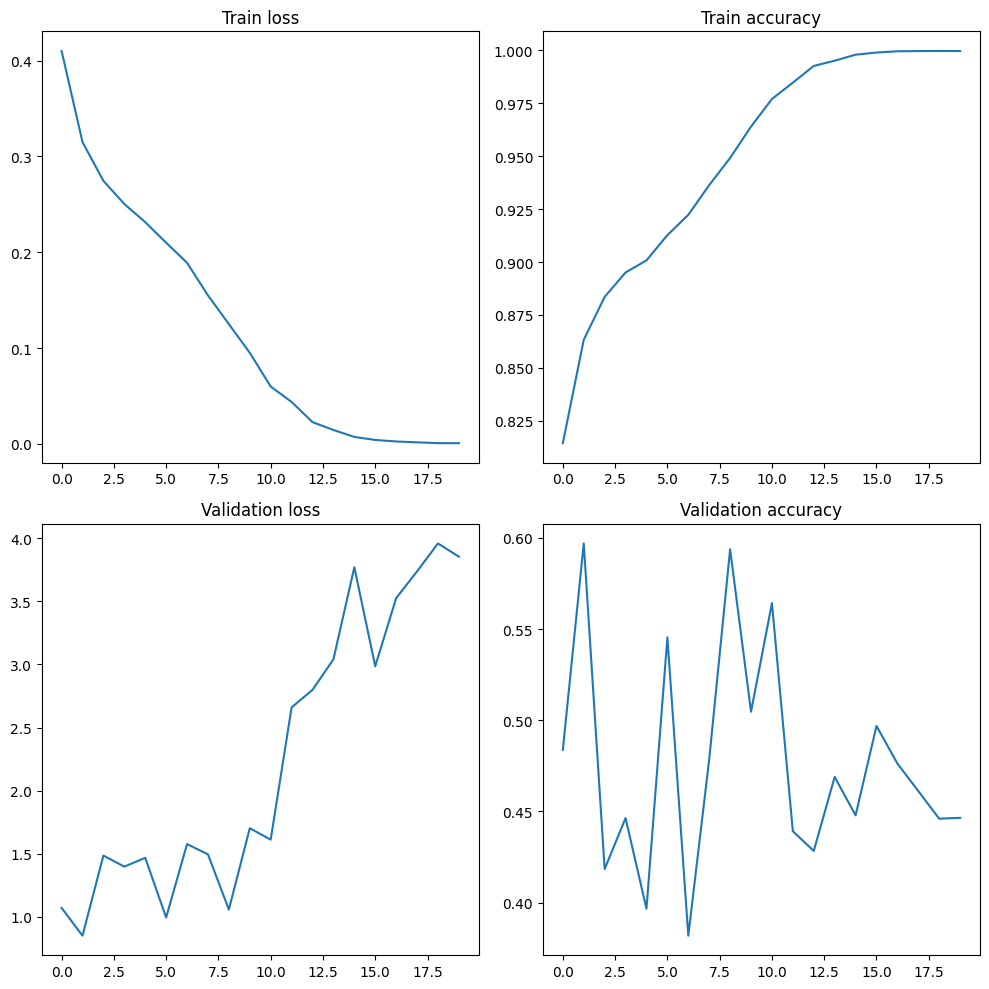

In [14]:
plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy)

# ResNet 18

- ImageNet Weights (v1)
- Batch size: **8**
- Gradient clip: **disabled**
- Weight Decay: **disabled**
- **5** epochs

In [17]:
config = dict()
config['MODEL'] = 'resnet18'
config['MODEL_PRETRAINED'] = True
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 8
config['LR'] = 3e-4
config['GRAD_CLIP'] = None
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 0
config['NUM_EPOCHS'] = 5

In [18]:
train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy = run_experiment(config)

Epoch #0 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [12:35<00:00,  3.08it/s]


Train loss: 0.28531227065082254, accuracy: 0.8833225965499878


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:54<00:00,  5.03it/s]


Validation loss: 0.48617814988880365, accuracy: 0.776190459728241
Saving best accuracy so far, 0.776190459728241
Epoch #1 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [11:31<00:00,  3.36it/s]


Train loss: 0.2282280832864312, accuracy: 0.9109213948249817


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:48<00:00,  5.68it/s]


Validation loss: 1.3699517036095643, accuracy: 0.31804028153419495
Epoch #2 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [11:23<00:00,  3.41it/s]


Train loss: 0.16085042000983849, accuracy: 0.9379832744598389


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:52<00:00,  5.24it/s]


Validation loss: 1.2027504580443378, accuracy: 0.5078754425048828
Epoch #3 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [11:41<00:00,  3.32it/s]


Train loss: 0.08722907145595345, accuracy: 0.9655820727348328


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.77it/s]


Validation loss: 1.6906819283525585, accuracy: 0.38424909114837646
Epoch #4 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [11:09<00:00,  3.48it/s]


Train loss: 0.03042896591914135, accuracy: 0.9894222617149353


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:49<00:00,  5.54it/s]


Validation loss: 1.9937801785705673, accuracy: 0.4573259949684143


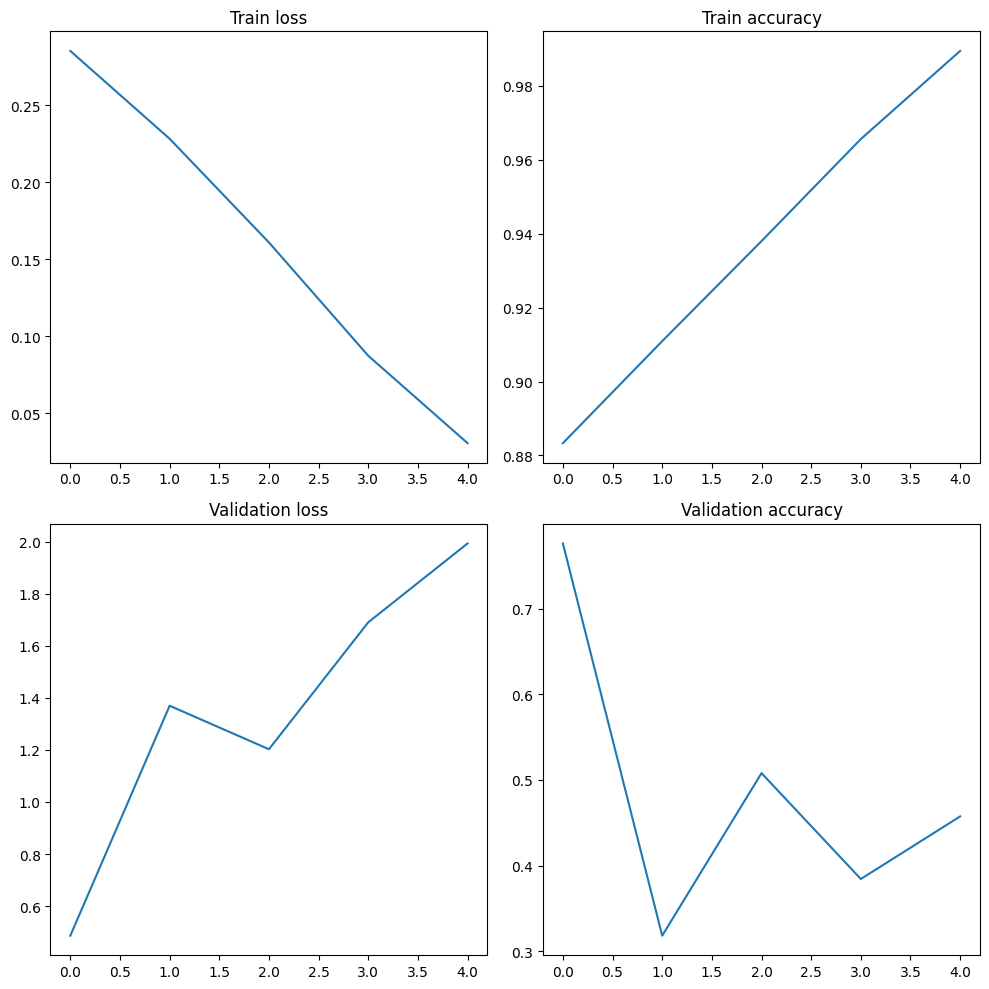

In [20]:
plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy)

# ResNet 34

- No Weights
- Batch size: **8**
- Gradient clip: **disabled**
- Weight Decay: **disabled**
- **10** epochs

In [21]:
config = dict()
config['MODEL'] = 'resnet34'
config['MODEL_PRETRAINED'] = False
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 8
config['LR'] = 3e-4
config['GRAD_CLIP'] = None
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 0
config['NUM_EPOCHS'] = 10

In [22]:
train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy = run_experiment(config)

Epoch #0 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [15:09<00:00,  2.56it/s]


Train loss: 0.43327011096313645, accuracy: 0.7984858155250549


100%|███████████████████████████████████████████████████████████████████| 273/273 [01:16<00:00,  3.59it/s]


Validation loss: 1.2714456426245826, accuracy: 0.42106226086616516
Saving best accuracy so far, 0.42106226086616516
Epoch #1 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [13:51<00:00,  2.80it/s]


Train loss: 0.32830980719111963, accuracy: 0.8523947596549988


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:56<00:00,  4.87it/s]


Validation loss: 0.7849751288965071, accuracy: 0.6035714149475098
Saving best accuracy so far, 0.6035714149475098
Epoch #2 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [13:15<00:00,  2.93it/s]


Train loss: 0.2832492961489461, accuracy: 0.8754832744598389


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:55<00:00,  4.94it/s]


Validation loss: 2.0241471322529674, accuracy: 0.4207875430583954
Epoch #3 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [14:00<00:00,  2.77it/s]


Train loss: 0.2514464688428143, accuracy: 0.8904102444648743


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:56<00:00,  4.82it/s]


Validation loss: 0.9811493324477485, accuracy: 0.507509171962738
Epoch #4 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [14:02<00:00,  2.76it/s]


Train loss: 0.22394463637922937, accuracy: 0.9048002362251282


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:54<00:00,  4.96it/s]


Validation loss: 1.1183603976890717, accuracy: 0.4522893726825714
Epoch #5 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [13:14<00:00,  2.93it/s]


Train loss: 0.18605108192023306, accuracy: 0.9223582744598389


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:57<00:00,  4.77it/s]


Validation loss: 1.4653459785168397, accuracy: 0.4601648449897766
Epoch #6 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [13:47<00:00,  2.81it/s]


Train loss: 0.1456225725923264, accuracy: 0.9398088455200195


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:55<00:00,  4.91it/s]


Validation loss: 1.8595865893249328, accuracy: 0.41108056902885437
Epoch #7 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [14:14<00:00,  2.72it/s]


Train loss: 0.09868549300193978, accuracy: 0.961877167224884


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:59<00:00,  4.62it/s]


Validation loss: 2.2692375226788934, accuracy: 0.4463369846343994
Epoch #8 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [16:14<00:00,  2.39it/s]


Train loss: 0.04808210780814476, accuracy: 0.9844824075698853


100%|███████████████████████████████████████████████████████████████████| 273/273 [01:20<00:00,  3.39it/s]


Validation loss: 1.9329880694773445, accuracy: 0.5161172151565552
Epoch #9 started.


100%|█████████████████████████████████████████████████████████████████| 2328/2328 [14:34<00:00,  2.66it/s]


Train loss: 0.027829031517663503, accuracy: 0.9907109141349792


100%|███████████████████████████████████████████████████████████████████| 273/273 [00:56<00:00,  4.87it/s]


Validation loss: 2.1990070445207204, accuracy: 0.47747254371643066


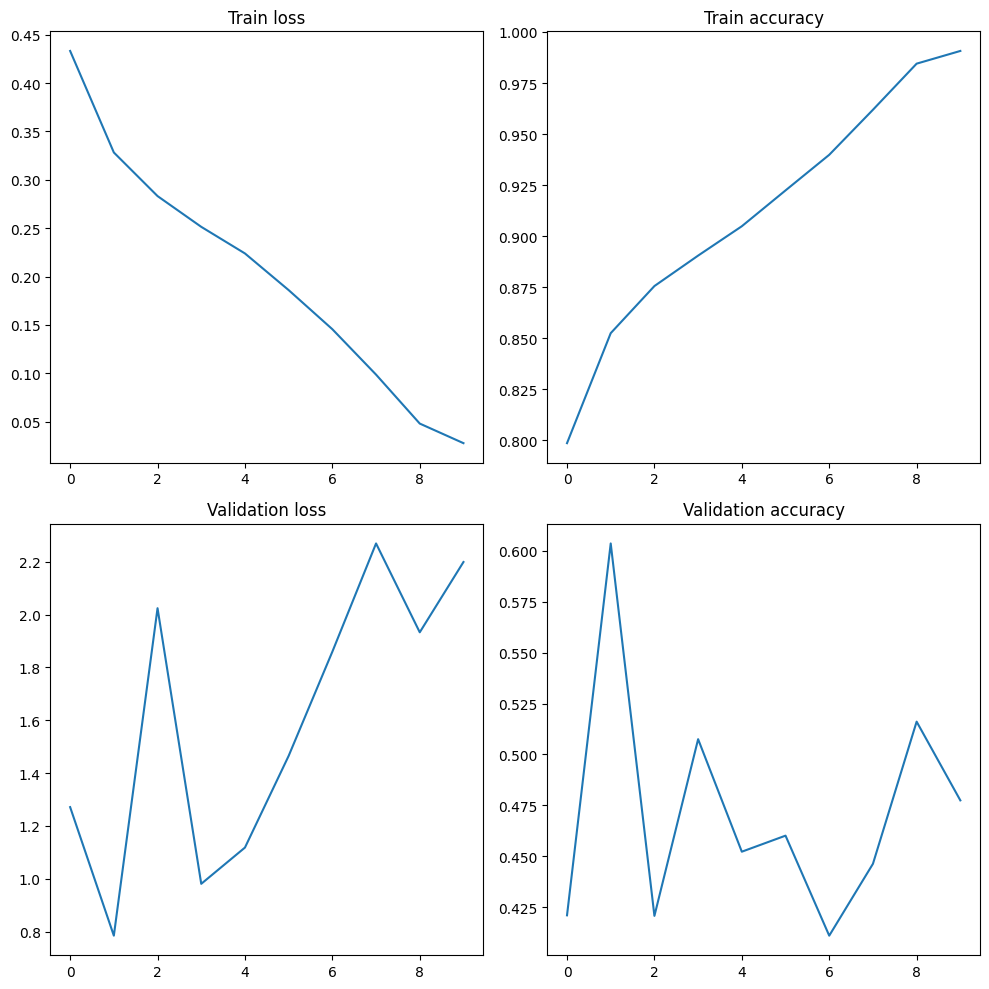

In [23]:
plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy)

# ResNet 34

- ImageNet Weights
- Batch size: **8**
- Gradient clip: **disabled**
- Weight Decay: **disabled**
- **10** epochs

In [15]:
config = dict()
config['MODEL'] = 'resnet34'
config['MODEL_PRETRAINED'] = True
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 8
config['LR'] = 3e-4
config['GRAD_CLIP'] = None
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 0
config['NUM_EPOCHS'] = 10

In [16]:
train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy = run_experiment(config)

Epoch #0 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:41<00:00,  3.63it/s]


Train loss: 0.26755893214346116, accuracy: 0.8895511031150818


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.75it/s]


Validation loss: 0.6415031328660883, accuracy: 0.6934981346130371
Saving best accuracy so far, 0.6934981346130371
Epoch #1 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:28<00:00,  3.38it/s]


Train loss: 0.21457713521649754, accuracy: 0.9141967296600342


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:49<00:00,  5.49it/s]


Validation loss: 1.781698879413989, accuracy: 0.39322343468666077
Epoch #2 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:41<00:00,  3.63it/s]


Train loss: 0.192102091939487, accuracy: 0.9241838455200195


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:46<00:00,  5.87it/s]


Validation loss: 1.5116661487918197, accuracy: 0.26355311274528503
Epoch #3 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:55<00:00,  3.55it/s]


Train loss: 0.15536594604037196, accuracy: 0.9403994679450989


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:49<00:00,  5.47it/s]


Validation loss: 1.9897249208374337, accuracy: 0.357051283121109
Epoch #4 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:41<00:00,  3.63it/s]


Train loss: 0.12697532644233434, accuracy: 0.9499570727348328


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:47<00:00,  5.77it/s]


Validation loss: 1.1080221946149955, accuracy: 0.5363553166389465
Epoch #5 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:36<00:00,  3.66it/s]


Train loss: 0.09409191364886152, accuracy: 0.9626825451850891


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:52<00:00,  5.20it/s]


Validation loss: 1.659930278366302, accuracy: 0.40549448132514954
Epoch #6 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:56<00:00,  3.25it/s]


Train loss: 0.05572331322684502, accuracy: 0.978468656539917


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:51<00:00,  5.34it/s]


Validation loss: 2.374000458319709, accuracy: 0.4227106273174286
Epoch #7 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:37<00:00,  3.65it/s]


Train loss: 0.023238229666632023, accuracy: 0.9919995665550232


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.23it/s]


Validation loss: 2.489029578647948, accuracy: 0.43214285373687744
Epoch #8 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:38<00:00,  3.65it/s]


Train loss: 0.00593285065790431, accuracy: 0.9984965920448303


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:45<00:00,  6.05it/s]


Validation loss: 2.6953486935798447, accuracy: 0.4545787572860718
Epoch #9 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:51<00:00,  3.57it/s]


Train loss: 0.003105537830565534, accuracy: 0.999355673789978


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:49<00:00,  5.48it/s]

Validation loss: 2.3641226081870115, accuracy: 0.49853482842445374


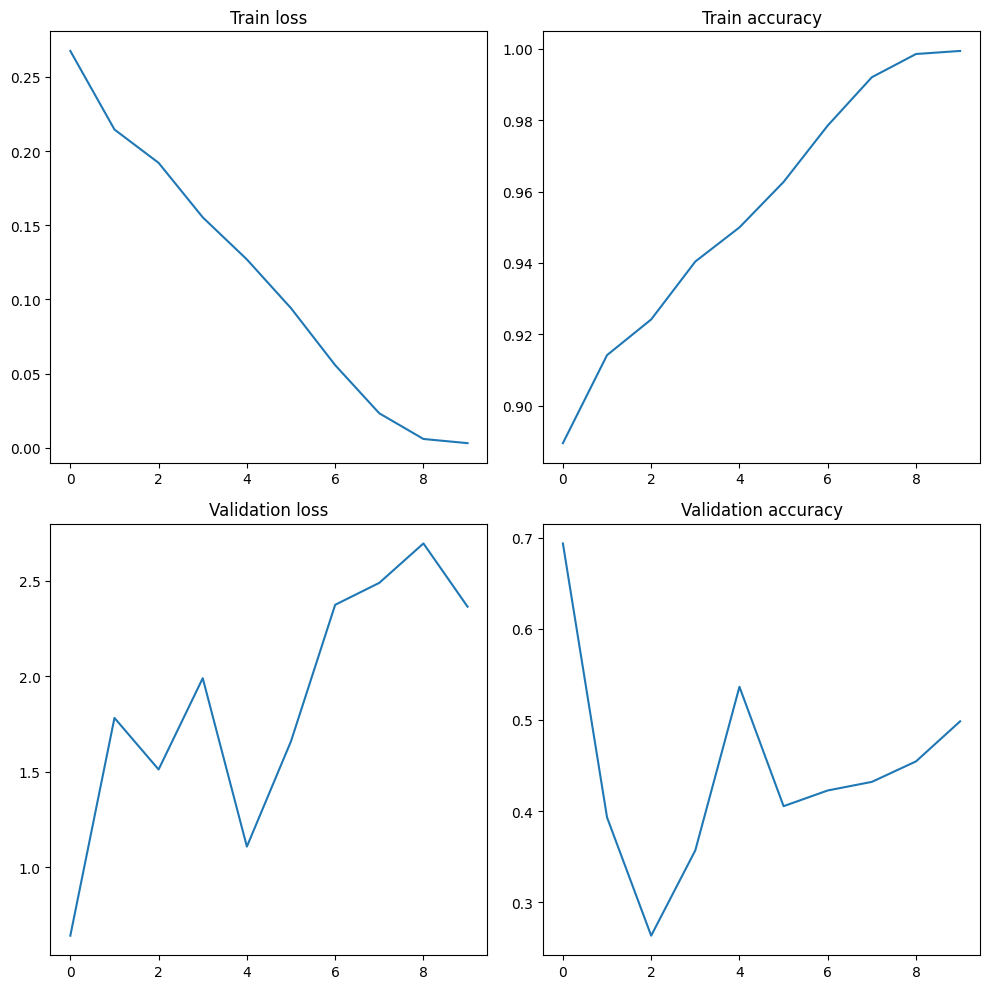

In [17]:
plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy)

# ResNet 50

- ImageNet Weights
- Batch size: **8**
- Gradient clip: **disabled**
- Weight Decay: **disabled**
- **10** epochs

In [18]:
config = dict()
config['MODEL'] = 'resnet50'
config['MODEL_PRETRAINED'] = True
config['NUM_CLASSES'] = 2
config['NUM_WORKERS'] = 0
config['BATCH_SIZE'] = 8
config['LR'] = 3e-4
config['GRAD_CLIP'] = None
config['DEVICE'] = 'cpu' if not torch.cuda.is_available() else 'cuda'
config['WEIGHT_DECAY'] = 0
config['NUM_EPOCHS'] = 10

In [19]:
train_loss, train_accuracy, val_loss, val_accuracy, best_accuracy = run_experiment(config)

Epoch #0 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:41<00:00,  3.32it/s]


Train loss: 0.27605439624685113, accuracy: 0.8897659182548523


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:51<00:00,  5.30it/s]


Validation loss: 1.0264755466700473, accuracy: 0.48974359035491943
Saving best accuracy so far, 0.48974359035491943
Epoch #1 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:32<00:00,  3.36it/s]


Train loss: 0.18570410325015893, accuracy: 0.9290163516998291


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:45<00:00,  5.99it/s]


Validation loss: 1.5197426303402408, accuracy: 0.420695960521698
Epoch #2 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:43<00:00,  3.62it/s]


Train loss: 0.14777479300501875, accuracy: 0.9403994679450989


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:45<00:00,  5.99it/s]


Validation loss: 1.6189372941797033, accuracy: 0.4353479743003845
Epoch #3 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:50<00:00,  3.58it/s]


Train loss: 0.12084718018339811, accuracy: 0.9508698582649231


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:45<00:00,  6.04it/s]


Validation loss: 1.5935746959714225, accuracy: 0.38168495893478394
Epoch #4 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:49<00:00,  3.58it/s]


Train loss: 0.0910838305205673, accuracy: 0.9643470644950867


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:45<00:00,  6.04it/s]


Validation loss: 2.527839914039323, accuracy: 0.36639195680618286
Epoch #5 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:32<00:00,  3.36it/s]


Train loss: 0.0629518526405758, accuracy: 0.9750322103500366


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:50<00:00,  5.39it/s]


Validation loss: 2.360375925448242, accuracy: 0.3989926874637604
Epoch #6 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:21<00:00,  3.41it/s]


Train loss: 0.030781770989508957, accuracy: 0.9886168241500854


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:44<00:00,  6.10it/s]


Validation loss: 5.105479766598425, accuracy: 0.3928571343421936
Epoch #7 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:41<00:00,  3.63it/s]


Train loss: 0.010064593284558812, accuracy: 0.9968320727348328


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:43<00:00,  6.30it/s]


Validation loss: 4.6729404802300145, accuracy: 0.4156593382358551
Epoch #8 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [10:40<00:00,  3.64it/s]


Train loss: 0.0038930192998704667, accuracy: 0.9987650513648987


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:50<00:00,  5.44it/s]


Validation loss: 6.323426536511461, accuracy: 0.3781135380268097
Epoch #9 started.


100%|███████████████████████████████████████████████████████████████████████████████| 2328/2328 [11:01<00:00,  3.52it/s]


Train loss: 0.0017879533162774373, accuracy: 0.9994093775749207


100%|█████████████████████████████████████████████████████████████████████████████████| 273/273 [00:50<00:00,  5.39it/s]

Validation loss: 6.704585526922576, accuracy: 0.377197802066803


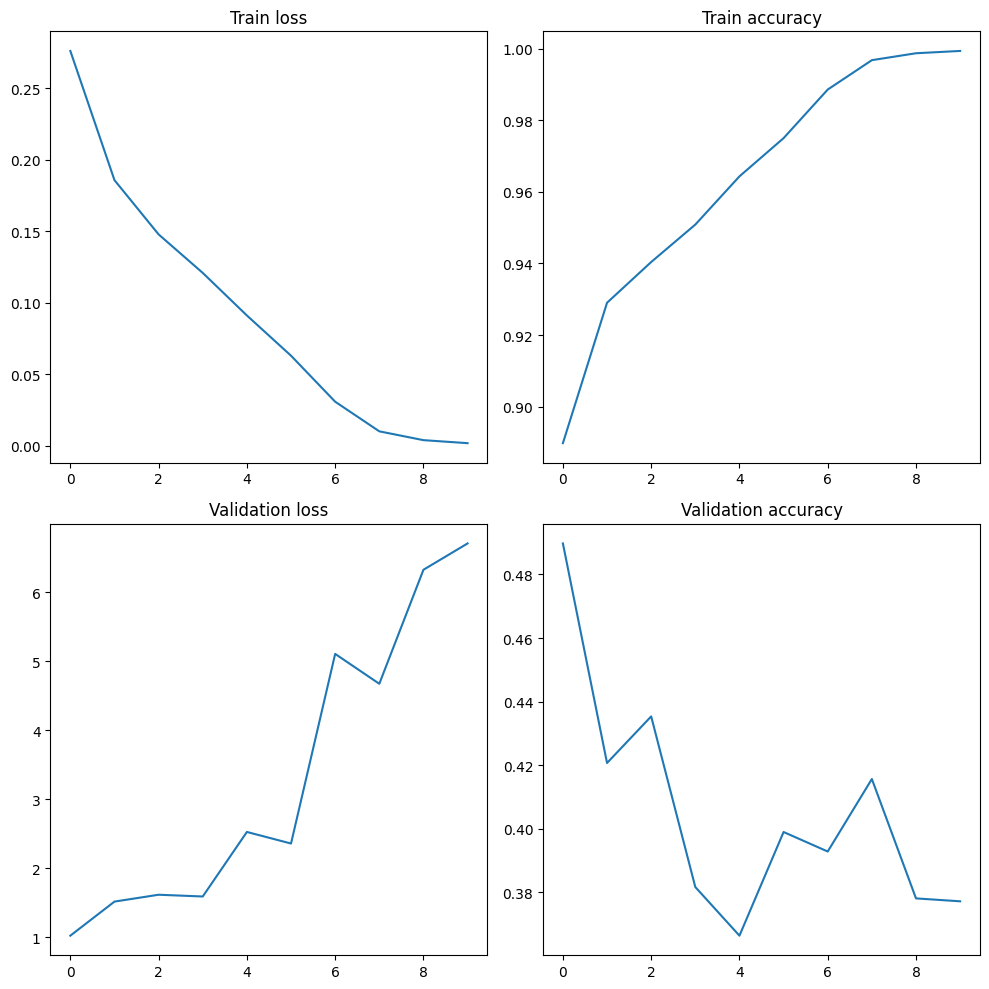

In [20]:
plot_experiment(train_loss, train_accuracy, val_loss, val_accuracy)

# Visualising results

In [41]:
def plot_results(model, state_file, dataset, transform, indices, row_size=8, title=None):
    state = torch.load(state_file)
    model = create_net(num_classes=2, model_type=model, pretrained=False)
    model.load_state_dict(state['state_dict'])
    
    fig, ax = plt.subplots(nrows=math.ceil(len(indices) / row_size), ncols=row_size, figsize=(16, 16))

    if title:
        fig.suptitle(f'Fake vs. Real Dataset: {title}', fontsize=28)
    else:
        fig.suptitle('Fake vs. Real Dataset', fontsize=28)
    
    for i, index in enumerate(indices):
        image, probs = dataset[index]
        label_id = np.argmax(probs)

        predictions = model(transform(image).unsqueeze(0))
        predicted_id = np.argmax(predictions.detach().cpu().numpy())

        if type(image) is torch.tensor:
            image = image.detach().cpu().numpy()
            image = image.transpose((1, 2, 0))

        grid_i = i // row_size
        grid_j = i % row_size

        ax[grid_i, grid_j].axis("off")
        ax[grid_i, grid_j].set_title(f"Real: {CLASSES_NAMES[label_id]}\nPredicted: {CLASSES_NAMES[predicted_id]}")
        ax[grid_i, grid_j].imshow(image)

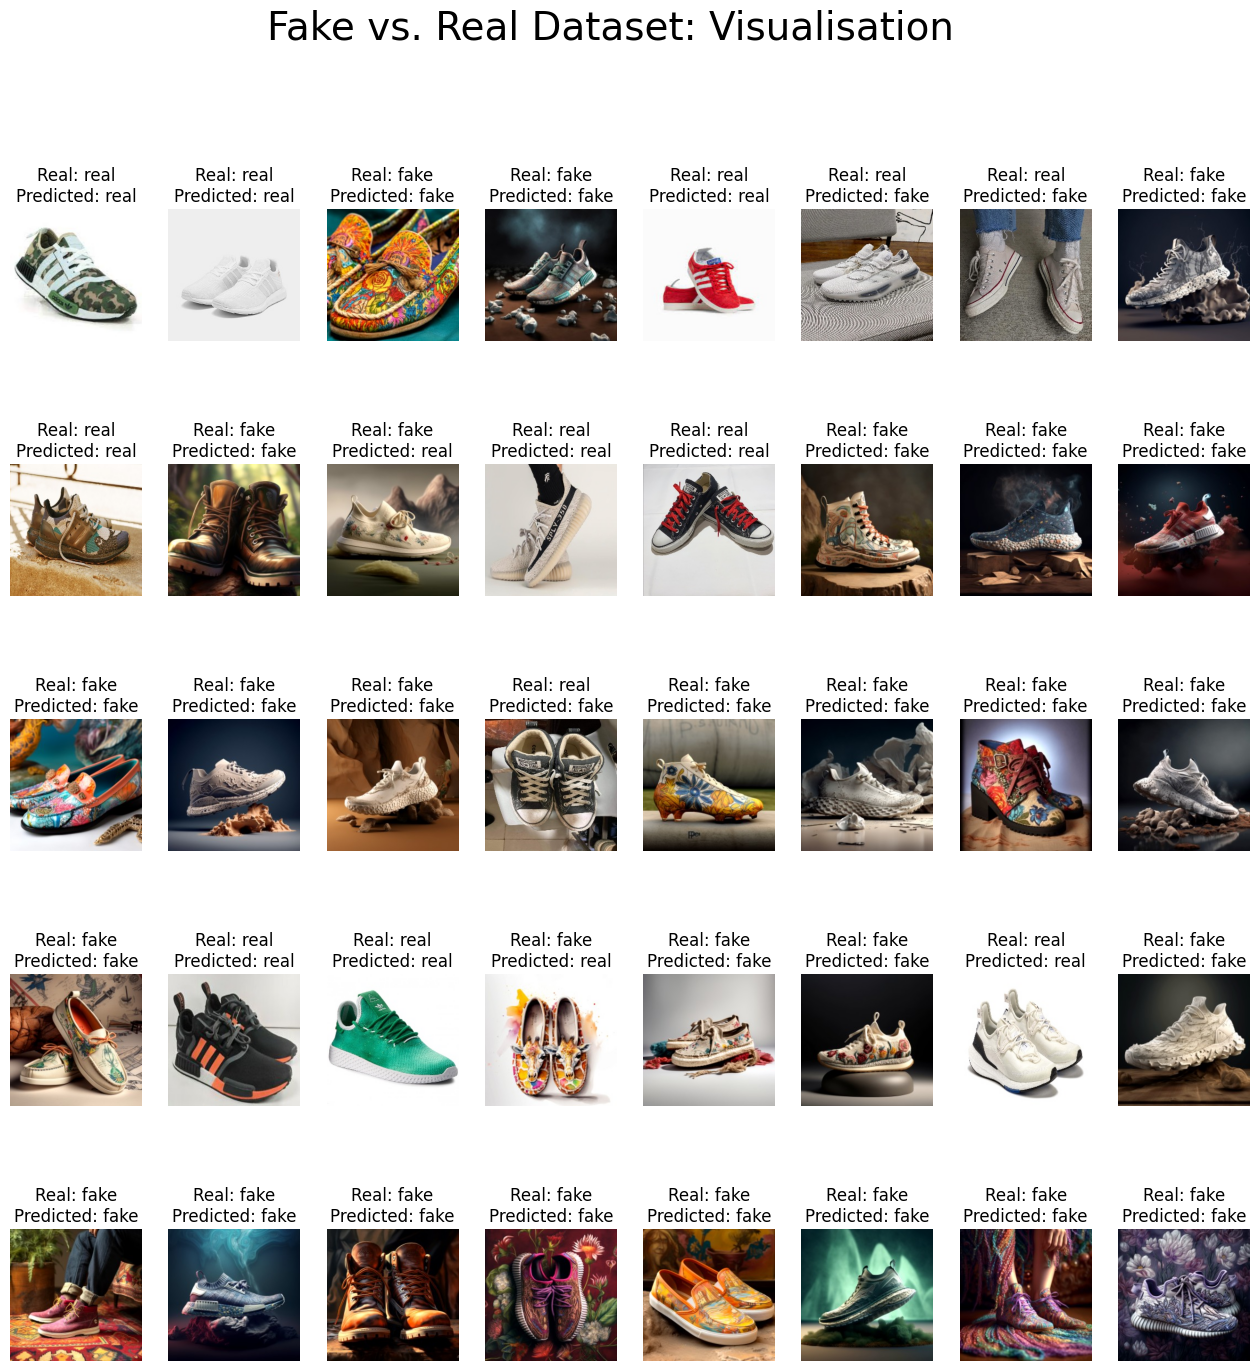

In [45]:
dataset = DeepFakeDataset('./temp/dataset', split='test')
indices = np.random.randint(0, len(dataset), 40)

plot_results('resnet18', './temp/resnet18_acc0.60.pth', dataset=dataset, indices=indices, title='Visualisation', transform=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
]))